## Garton Research & Trading
### Volatility Study - January 23rd, 2019

Author: Matthew T. Garton

*Purpose:* The purpose of this notebook is to study statistical properties and relationships of implied volatility on the S&P500 Index, specifically through an analysis of the VIX Index itself. I will look at the VIX, the implied vol of vol, represented by the VVIX Index, as well as the SKEW Index, a representation of supply and demand for downside versus upside protection. The findings here may support a trade thesis, but in the absence of any conclusive evidence, the study is merely an academic exercise in understanding the volatility market.

Finally, I will conclude with a Monte Carlo simulation of three month returns on the S&P 500 Index, to form the basis of a risk/reward analysis on an options trade.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf, pacf, adfuller

from odo import odo # data operations; to use data as df

# import desired datasets from Quantopian Interactive
from quantopian.interactive.data.quandl import cboe_vix, cboe_vvix, cboe_skew 

In [5]:
# create dataframes for datasets
vix_df = odo(cboe_vix.sort('asof_date'), pd.DataFrame)
vvix_df = odo(cboe_vvix.sort('asof_date'), pd.DataFrame)
skew_df = odo(cboe_skew.sort('asof_date'), pd.DataFrame)

In [6]:
# inspect dfs - start with VIX
# VIX - 2004 to 2019
# VVIX - 2007  to 2019
# SKEW - 1990 to 2019

print(vix_df.head())
print(vix_df.tail())
vix_df.info()

   vix_open  vix_high  vix_low  vix_close  asof_date  \
0     17.96     18.68    17.54      18.22 2004-01-02   
1     18.45     18.49    17.44      17.49 2004-01-05   
2     17.66     17.67    16.19      16.73 2004-01-06   
3     16.72     16.75    15.50      15.50 2004-01-07   
4     15.42     15.68    15.32      15.61 2004-01-08   

                   timestamp  
0 2004-01-03 10:59:02.223524  
1 2004-01-06 10:59:02.223524  
2 2004-01-07 10:59:02.223524  
3 2004-01-08 10:59:02.223524  
4 2004-01-09 10:59:02.223524  
      vix_open  vix_high  vix_low  vix_close  asof_date  \
3788     18.53     21.15    18.20      20.80 2019-01-22   
3789     20.85     22.02    19.47      19.52 2019-01-23   
3790     19.69     20.25    18.63      18.89 2019-01-24   
3791     18.43     18.46    17.31      17.42 2019-01-25   
3792     18.56     20.42    18.42      18.87 2019-01-28   

                      timestamp  
3788 2019-01-23 06:06:24.430706  
3789 2019-01-24 06:05:28.902140  
3790 2019-01-25 06:0

In [13]:
# Index dfs by time
vix_df.set_index(vix_df['asof_date'], inplace=True)
vvix_df.set_index(vvix_df['asof_date'], inplace=True)
skew_df.set_index(skew_df['asof_date'], inplace=True)

vix_df.describe()

,vix_open,vix_high,vix_low,vix_close,returns
count,3793.000000,3793.000000,3793.000000,3793.000000,3792.000000
mean,18.514115,19.370994,17.660778,18.414316,0.002532
std,8.823860,9.410604,8.213880,8.789050,0.072849
min,9.010000,9.310000,8.560000,9.140000,-0.323188
25%,13.060000,13.520000,12.560000,12.950000,NaN
50%,15.850000,16.540000,15.190000,15.750000,NaN
75%,21.060000,22.090000,20.050000,20.910000,NaN
max,80.740000,89.530000,72.760000,80.860000,1.023861


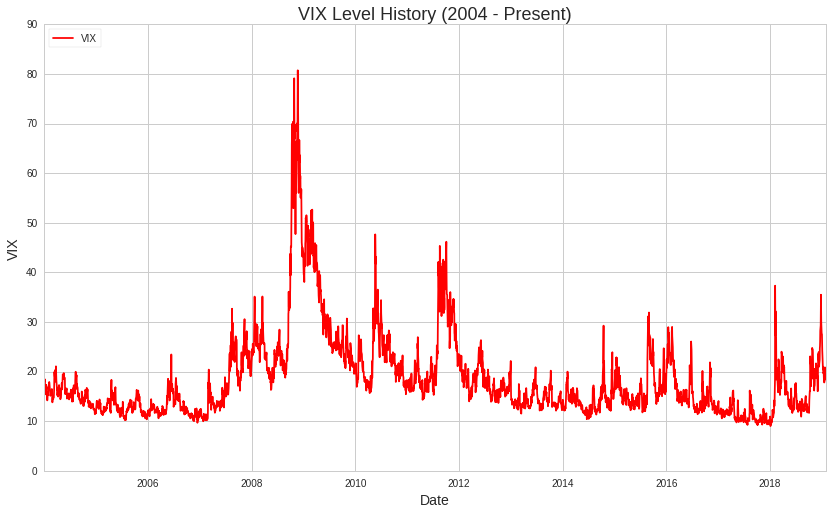

In [14]:
# Basic EDA - Let's look at some simple visualizations of the data
plt.plot(vix_df['vix_open'], color='r')
plt.xlabel('Date', fontsize=14)
plt.ylabel('VIX', fontsize=14)
plt.title('VIX Level History (2004 - Present)', fontsize=18)
plt.legend(['VIX'], loc=2);

In [15]:
# Distribution of Daily Returns
vix_df['returns'] = vix_df['vix_open'].pct_change(1)

VIX returns are likely not normal.


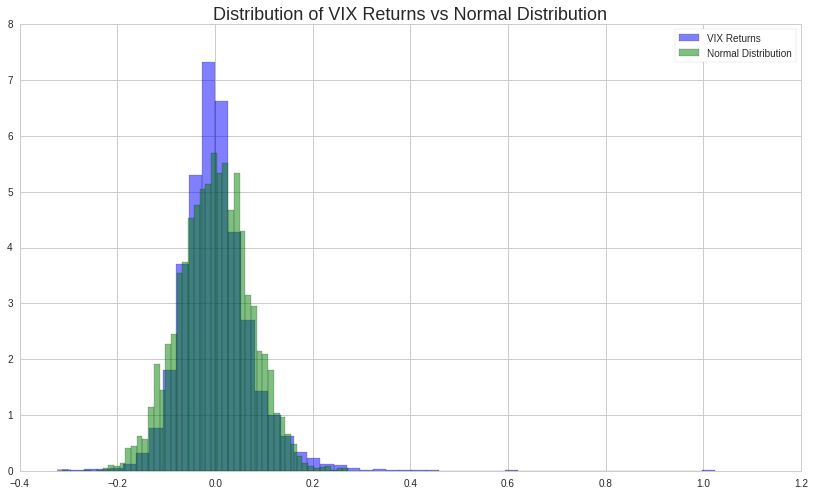

In [16]:
returns = vix_df['returns'].dropna()

_, pv, _, _ = jarque_bera(returns)

if pv > 0.05:
    print('VIX returns are likely normal.')
else:
    print('VIX returns are likely not normal.')

normal = np.random.normal(loc=returns.mean(), scale=np.sqrt(returns.var()), size=len(returns))
plt.hist(returns, bins = 50, color='b', alpha=0.5, normed=True, label='VIX Returns')
plt.hist(normal, bins = 50, color='g', alpha=0.5, normed=True, label='Normal Distribution')
plt.title('Distribution of VIX Returns vs Normal Distribution', fontsize=18)
plt.legend();

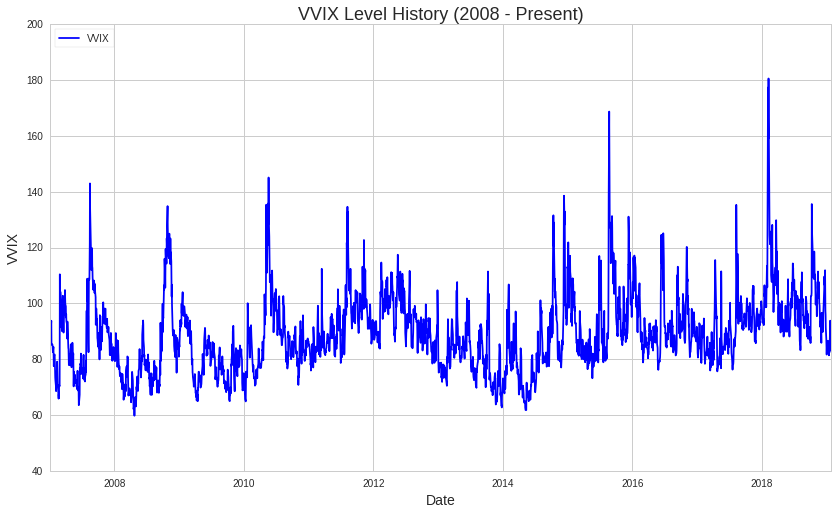

In [20]:
# ...now let's look at VVIX over time...
plt.plot(vvix_df['vvix'], color='b')
plt.xlabel('Date', fontsize=14)
plt.ylabel('VVIX', fontsize=14)
plt.title('VVIX Level History (2008 - Present)', fontsize=18)
plt.legend(['VVIX'], loc=2);

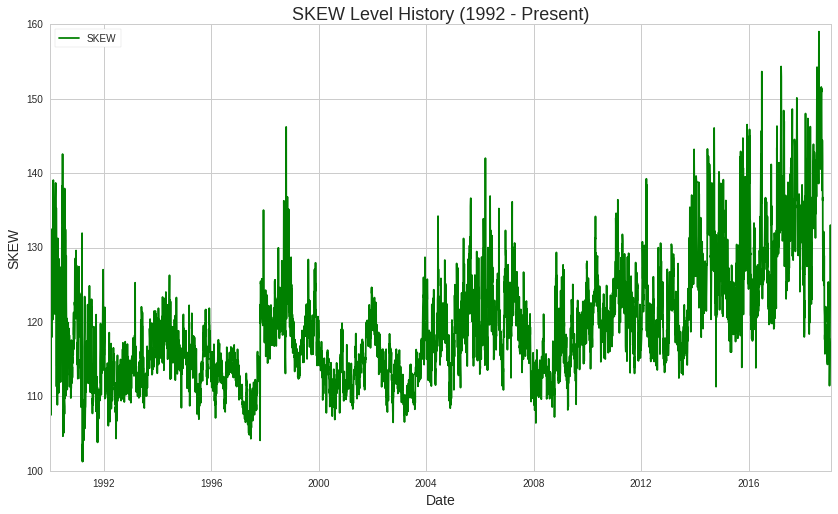

In [22]:
# ...and SKEW...
plt.plot(skew_df['skew'], color='g')
plt.xlabel('Date', fontsize=14)
plt.ylabel('SKEW', fontsize=14)
plt.title('SKEW Level History (1992 - Present)', fontsize=18)
plt.legend(['SKEW'], loc=2);

VVIX levels are likely not normal.


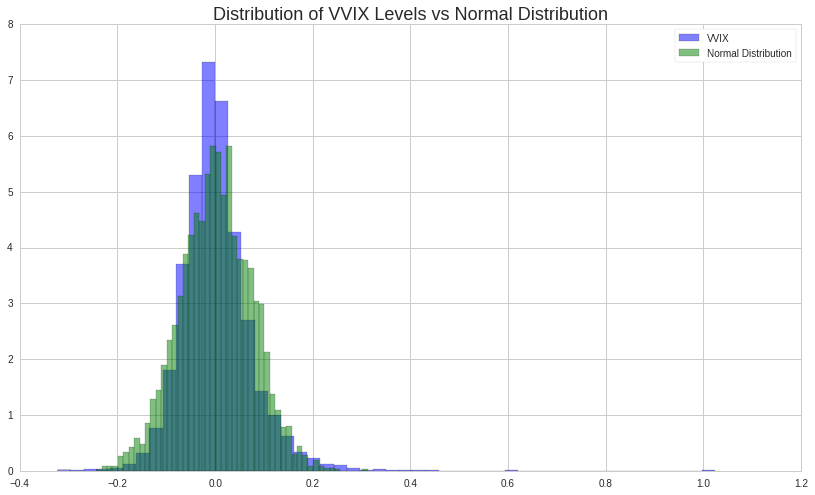

In [25]:
# What do the distributions of vvix and skew look like?
_, pv, _, _ = jarque_bera(vvix_df['vvix'])

if pv > 0.05:
    print('VVIX levels are likely normal.')
else:
    print('VVIX levels are likely not normal.')

normal = np.random.normal(loc=returns.mean(), scale=np.sqrt(returns.var()), size=len(returns))
plt.hist(returns, bins = 50, color='b', alpha=0.5, normed=True, label='VVIX')
plt.hist(normal, bins = 50, color='g', alpha=0.5, normed=True, label='Normal Distribution')
plt.title('Distribution of VVIX Levels vs Normal Distribution', fontsize=18)
plt.legend();

Skew levels are likely not normal.


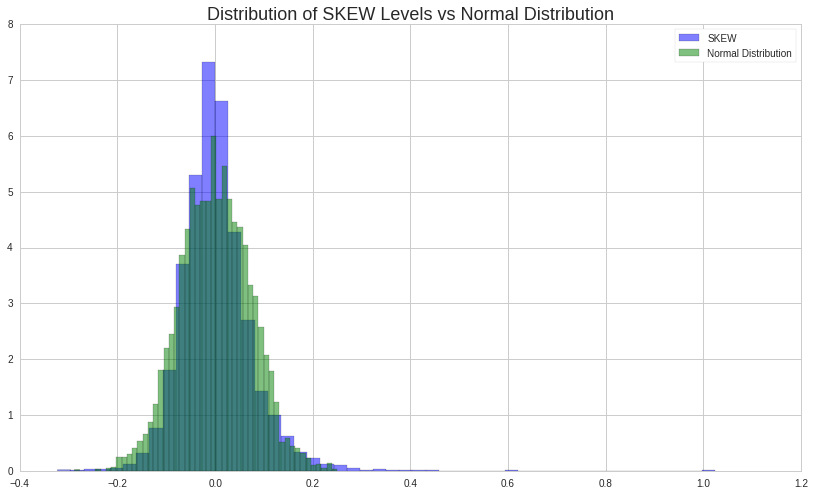

In [26]:
_, pv, _, _ = jarque_bera(skew_df['skew'])

if pv > 0.05:
    print('Skew levels are likely normal.')
else:
    print('Skew levels are likely not normal.')

normal = np.random.normal(loc=returns.mean(), scale=np.sqrt(returns.var()), size=len(returns))
plt.hist(returns, bins = 50, color='b', alpha=0.5, normed=True, label='SKEW')
plt.hist(normal, bins = 50, color='g', alpha=0.5, normed=True, label='Normal Distribution')
plt.title('Distribution of SKEW Levels vs Normal Distribution', fontsize=18)
plt.legend();

In [27]:
skew_df.describe()

,skew
count,7314.000000
mean,119.463339
std,7.814743
min,101.230000
25%,113.940000
50%,118.105000
75%,123.230000
max,159.030000


In [65]:
# merge dataframes to analyze relationships
vol_df = pd.merge(vix_df, skew_df, how='left', on=['asof_date'])

In [67]:
vol_df = pd.merge(vol_df, vvix_df, how='left', on=['asof_date'])